In [40]:
# ============================================================================
# 셀 1: 라이브러리 임포트
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score, 
                           roc_curve, precision_recall_curve, auc)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ 라이브러리 임포트 완료!")


✅ 라이브러리 임포트 완료!


In [41]:
# ============================================================================
# 셀 2: 데이터 로딩 및 전처리
# ============================================================================

# 데이터 로드
df = pd.read_excel("../data/raw/E Commerce Dataset.xlsx", sheet_name='E Comm')
print(f"✅ 데이터 로드 완료: {df.shape[0]:,}행 × {df.shape[1]}열")

# 데이터 복사본 생성
df_model = df.copy()

# 결측값 처리
numeric_missing_cols = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 
                       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']

for col in numeric_missing_cols:
    if col in df_model.columns:
        median_val = df_model[col].median()
        df_model[col].fillna(median_val, inplace=True)

# 범주형 변수 인코딩
categorical_features = ['Gender', 'MaritalStatus', 'CityTier', 'PreferredPaymentMode', 'PreferedOrderCat']
label_encoders = {}

for col in categorical_features:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[f'{col}_encoded'] = le.fit_transform(df_model[col])
        label_encoders[col] = le

# 피쳐 엔지니어링 (02번 노트북에서 생성한 피쳐들)
df_model['ActivityScore'] = (
    df_model['OrderCount'] * 0.4 + 
    df_model['HourSpendOnApp'] * 0.3 + 
    df_model['CouponUsed'] * 0.3
)

df_model['OrderFrequency'] = df_model['OrderCount'] / (df_model['Tenure'] + 1)

df_model['CustomerValueScore'] = (
    df_model['CashbackAmount'] * 0.5 + 
    df_model['OrderCount'] * 0.3 + 
    df_model['Tenure'] * 0.2
)

print("✅ 데이터 전처리 완료!")

✅ 데이터 로드 완료: 5,630행 × 20열
✅ 데이터 전처리 완료!


In [42]:
# ============================================================================
# 셀 3: 피쳐 선택 및 데이터 준비
# ============================================================================

# 모델링용 피쳐 선택
modeling_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                    'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
                    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
                    'ActivityScore', 'OrderFrequency', 'CustomerValueScore']

# 인코딩된 범주형 변수 추가
for col in categorical_features:
    if f'{col}_encoded' in df_model.columns:
        modeling_features.append(f'{col}_encoded')

# 데이터 준비
X = df_model[modeling_features].fillna(0)
y = df_model['Churn']

print(f"📊 모델링 데이터 크기: {X.shape}")
print(f"🎯 타겟 변수 분포:")
print(y.value_counts(normalize=True))

📊 모델링 데이터 크기: (5630, 19)
🎯 타겟 변수 분포:
Churn
0    0.831616
1    0.168384
Name: proportion, dtype: float64


In [43]:
# ============================================================================
# 셀 4: 데이터 분할
# ============================================================================

# 훈련/테스트 데이터 분할 (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 데이터 분할 결과:")
print(f"- 훈련 데이터: {X_train.shape[0]:,}개 샘플")
print(f"- 테스트 데이터: {X_test.shape[0]:,}개 샘플")
print(f"- 훈련 데이터 이탈률: {y_train.mean()*100:.1f}%")
print(f"- 테스트 데이터 이탈률: {y_test.mean()*100:.1f}%")

📊 데이터 분할 결과:
- 훈련 데이터: 4,504개 샘플
- 테스트 데이터: 1,126개 샘플
- 훈련 데이터 이탈률: 16.8%
- 테스트 데이터 이탈률: 16.9%


In [44]:
# ============================================================================
# 셀 5: 피쳐 스케일링
# ============================================================================

# StandardScaler 적용
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ 피쳐 스케일링 완료!")

✅ 피쳐 스케일링 완료!


In [45]:
# ============================================================================
# 셀 6: 클래스 불균형 확인 및 처리
# ============================================================================

# 클래스 불균형 확인
class_counts = y.value_counts()
print("📊 클래스 분포:")
print(f"- 유지 고객 (0): {class_counts[0]:,}명 ({class_counts[0]/len(y)*100:.1f}%)")
print(f"- 이탈 고객 (1): {class_counts[1]:,}명 ({class_counts[1]/len(y)*100:.1f}%)")

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

print(f"\n⚖️ 클래스 가중치:")
print(f"- 유지 고객 (0): {class_weight_dict[0]:.3f}")
print(f"- 이탈 고객 (1): {class_weight_dict[1]:.3f}")

📊 클래스 분포:
- 유지 고객 (0): 4,682명 (83.2%)
- 이탈 고객 (1): 948명 (16.8%)

⚖️ 클래스 가중치:
- 유지 고객 (0): 0.601
- 이탈 고객 (1): 2.969


In [46]:
# ============================================================================
# 셀 7: 기본 모델 성능 비교
# ============================================================================

# 다양한 모델 정의
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),  # 추가
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),  # 추가
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

# 모델 성능 평가
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("🔍 기본 모델 성능 비교:")
print("=" * 80)

for name, model in models.items():
    # 교차 검증
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    # 모델 훈련
    model.fit(X_train_scaled, y_train)
    
    # 예측
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # 성능 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std()
    }
    
    print(f"\n📌 {name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1-Score: {f1:.4f}")
    print(f"  - AUC: {auc_score:.4f}" if auc_score else "  - AUC: N/A")
    print(f"  - CV F1-Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

🔍 기본 모델 성능 비교:

📌 Logistic Regression:
  - Accuracy: 0.7753
  - Precision: 0.4097
  - Recall: 0.7526
  - F1-Score: 0.5306
  - AUC: 0.8319
  - CV F1-Score: 0.5460 (±0.0214)

📌 Random Forest:
  - Accuracy: 0.9760
  - Precision: 0.9880
  - Recall: 0.8684
  - F1-Score: 0.9244
  - AUC: 0.9955
  - CV F1-Score: 0.7997 (±0.0121)

📌 Gradient Boosting:
  - Accuracy: 0.9050
  - Precision: 0.8320
  - Recall: 0.5474
  - F1-Score: 0.6603
  - AUC: 0.9275
  - CV F1-Score: 0.6382 (±0.0470)

📌 XGBoost:
  - Accuracy: 0.9787
  - Precision: 0.9611
  - Recall: 0.9105
  - F1-Score: 0.9351
  - AUC: 0.9953
  - CV F1-Score: 0.8377 (±0.0253)

📌 LightGBM:
  - Accuracy: 0.9574
  - Precision: 0.9277
  - Recall: 0.8105
  - F1-Score: 0.8652
  - AUC: 0.9904
  - CV F1-Score: 0.8203 (±0.0284)

📌 SVM:
  - Accuracy: 0.8730
  - Precision: 0.5880
  - Recall: 0.8263
  - F1-Score: 0.6871
  - AUC: 0.9378
  - CV F1-Score: 0.6704 (±0.0224)

📌 KNN:
  - Accuracy: 0.9076
  - Precision: 0.8359
  - Recall: 0.5632
  - F1-Score: 0.6730

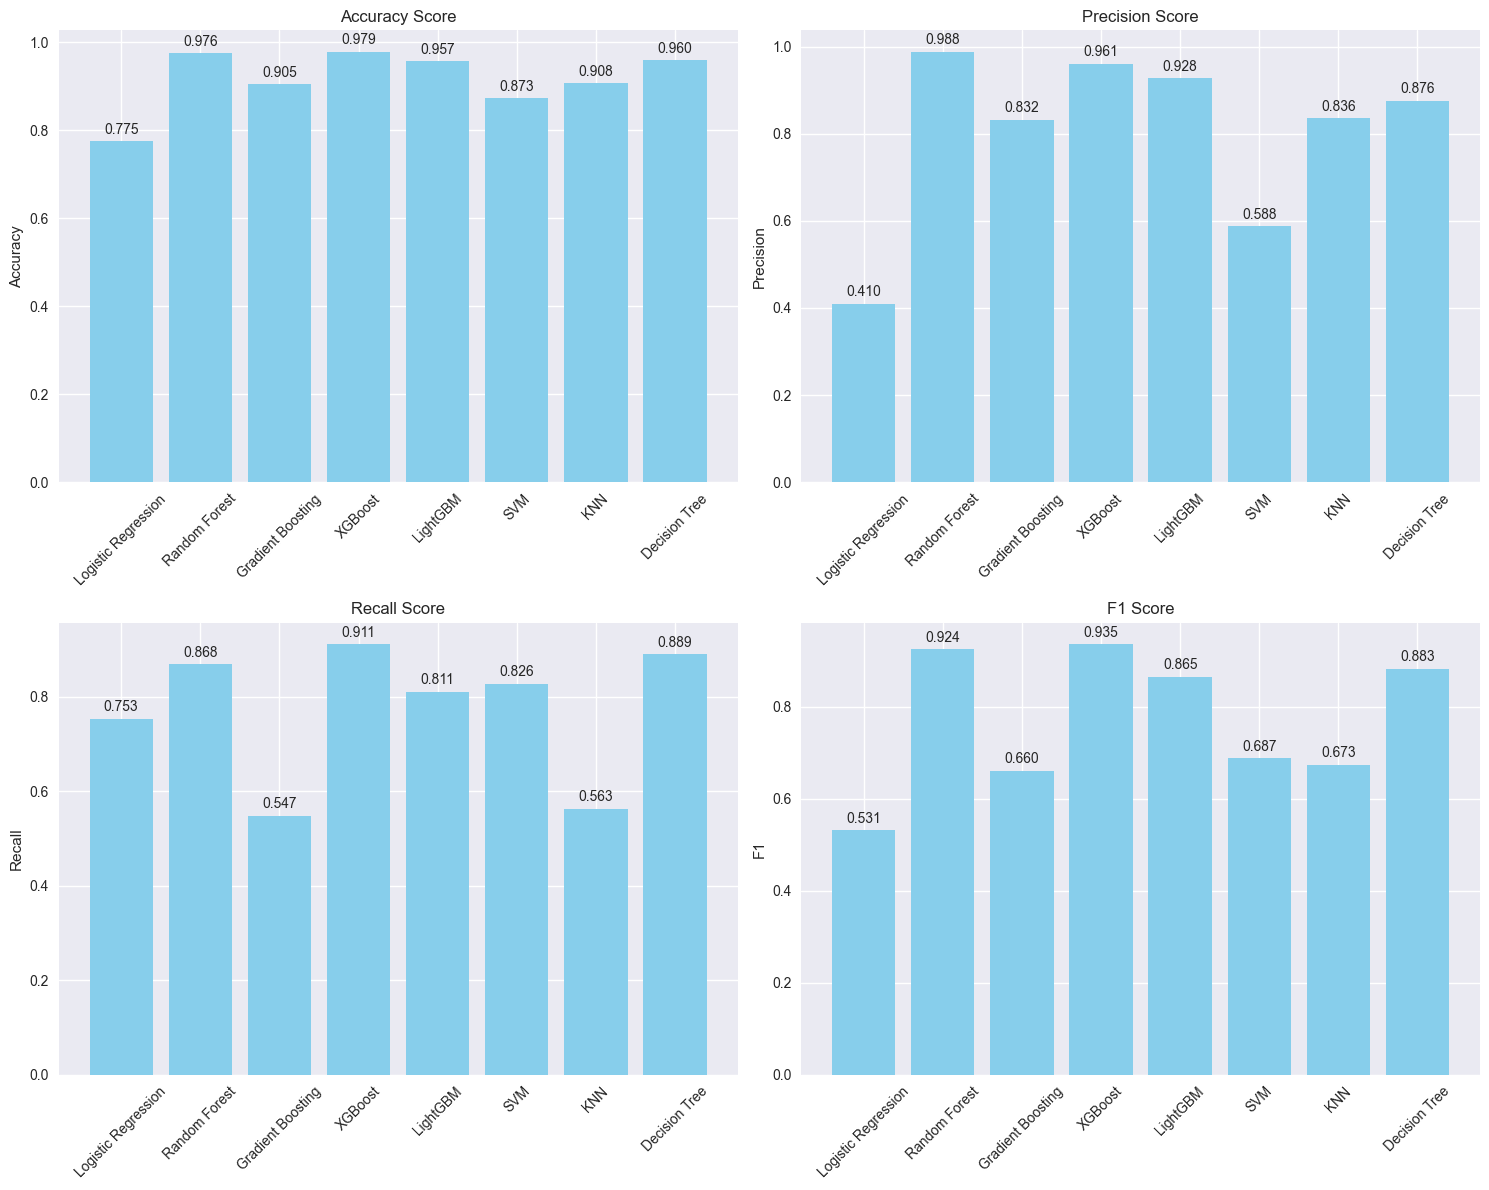

In [47]:
# ============================================================================
# 셀 8: 모델 성능 비교 시각화
# ============================================================================

# 성능 비교 시각화
metrics = ['accuracy', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in models.keys()]
    bars = axes[i].bar(models.keys(), values, color='skyblue')
    axes[i].set_title(f'{metric.title()} Score')
    axes[i].set_ylabel(metric.title())
    axes[i].tick_params(axis='x', rotation=45)
    
    # 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [48]:
# ============================================================================
# 셀 9: 최고 성능 모델 선택 및 하이퍼파라미터 튜닝
# ============================================================================

# 최고 F1 점수 모델 선택
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"🏆 최고 성능 모델: {best_model_name}")
print(f"   - F1 Score: {results[best_model_name]['f1']:.4f}")

# Random Forest 하이퍼파라미터 튜닝
if best_model_name == 'Random Forest':
    print("\n🔧 Random Forest 하이퍼파라미터 튜닝 중...")
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    grid_search = GridSearchCV(
        rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"✅ 최적 하이퍼파라미터: {grid_search.best_params_}")
    print(f"✅ 최적 F1 Score: {grid_search.best_score_:.4f}")
    
    # 최적 모델로 예측
    best_rf = grid_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test_scaled)
    y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n📊 튜닝된 Random Forest 성능:")
    print(f"- Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    print(f"- Precision: {precision_score(y_test, y_pred_rf):.4f}")
    print(f"- Recall: {recall_score(y_test, y_pred_rf):.4f}")
    print(f"- F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
    print(f"- AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
    
# XGBoost 하이퍼파라미터 튜닝
if best_model_name == 'XGBoost':
    print("\n�� XGBoost 하이퍼파라미터 튜닝 중...")
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    xgb = XGBClassifier(random_state=42, eval_metric='logloss')
    grid_search = GridSearchCV(
        xgb, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"✅ 최적 하이퍼파라미터: {grid_search.best_params_}")
    print(f"✅ 최적 F1 Score: {grid_search.best_score_:.4f}")
    
    best_xgb = grid_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test_scaled)
    y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n�� 튜닝된 XGBoost 성능:")
    print(f"- Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
    print(f"- Precision: {precision_score(y_test, y_pred_xgb):.4f}")
    print(f"- Recall: {recall_score(y_test, y_pred_xgb):.4f}")
    print(f"- F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
    print(f"- AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# LightGBM 하이퍼파라미터 튜닝
if best_model_name == 'LightGBM':
    print("\n�� LightGBM 하이퍼파라미터 튜닝 중...")
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    lgb = LGBMClassifier(random_state=42, verbose=-1)
    grid_search = GridSearchCV(
        lgb, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"✅ 최적 하이퍼파라미터: {grid_search.best_params_}")
    print(f"✅ 최적 F1 Score: {grid_search.best_score_:.4f}")
    
    best_lgb = grid_search.best_estimator_
    y_pred_lgb = best_lgb.predict(X_test_scaled)
    y_pred_proba_lgb = best_lgb.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n📊 튜닝된 LightGBM 성능:")
    print(f"- Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
    print(f"- Precision: {precision_score(y_test, y_pred_lgb):.4f}")
    print(f"- Recall: {recall_score(y_test, y_pred_lgb):.4f}")
    print(f"- F1-Score: {f1_score(y_test, y_pred_lgb):.4f}")
    print(f"- AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")

🏆 최고 성능 모델: XGBoost
   - F1 Score: 0.9351

�� XGBoost 하이퍼파라미터 튜닝 중...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
✅ 최적 하이퍼파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
✅ 최적 F1 Score: 0.8471

�� 튜닝된 XGBoost 성능:
- Accuracy: 0.9796
- Precision: 0.9718
- Recall: 0.9053
- F1-Score: 0.9373
- AUC: 0.9976


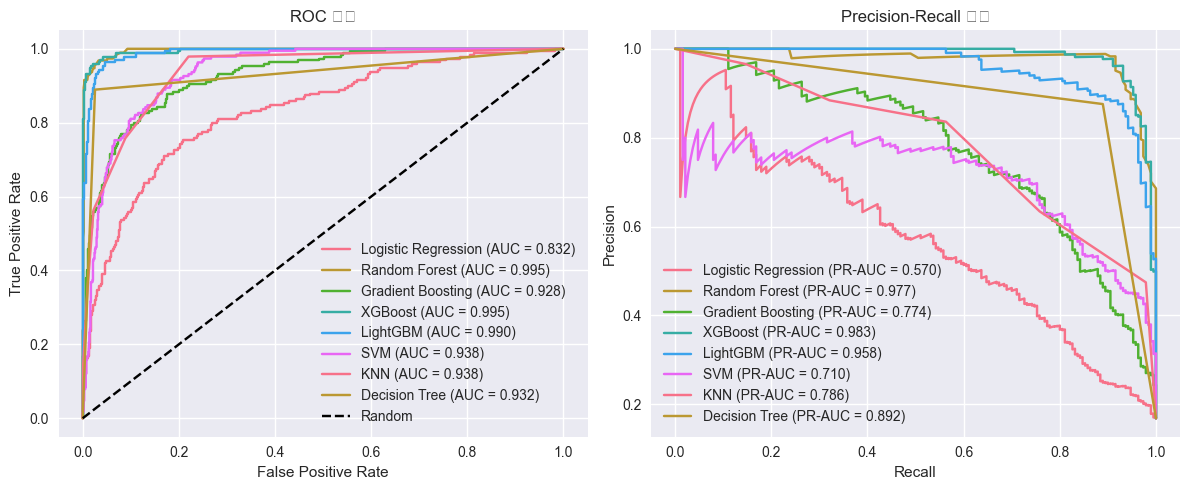

In [49]:
# ============================================================================
# 셀 11: ROC 곡선 및 AUC
# ============================================================================

# ROC 곡선 그리기
plt.figure(figsize=(12, 5))

# 서브플롯 1: ROC 곡선
plt.subplot(1, 2, 1)
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선')
plt.legend()
plt.grid(True)

# 서브플롯 2: Precision-Recall 곡선
plt.subplot(1, 2, 2)
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{name} (PR-AUC = {pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall 곡선')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
# ============================================================================
# 셀 12: 피쳐 중요도 분석 (Random Forest)
# ============================================================================

if best_model_name == 'Random Forest':
    # Random Forest 피쳐 중요도
    feature_importance = pd.DataFrame({
        'feature': modeling_features,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🎯 Random Forest 피쳐 중요도 (상위 10개):")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

elif best_model_name == 'XGBoost':
    # XGBoost 피쳐 중요도
    feature_importance = pd.DataFrame({
        'feature': modeling_features,
        'importance': best_xgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🎯 XGBoost 피쳐 중요도 (상위 10개):")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

elif best_model_name == 'LightGBM':
    # LightGBM 피쳐 중요도
    feature_importance = pd.DataFrame({
        'feature': modeling_features,
        'importance': best_lgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🎯 LightGBM 피쳐 중요도 (상위 10개):")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # 피쳐 중요도 시각화
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('피쳐 중요도')
    plt.title('Random Forest 피쳐 중요도 (상위 15개)')
    plt.gca().invert_yaxis()
    
    # 값 표시
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{importance:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

🎯 XGBoost 피쳐 중요도 (상위 10개):
 1. Tenure: 0.2656
 2. MaritalStatus_encoded: 0.0656
 3. DaySinceLastOrder: 0.0553
 4. NumberOfAddress: 0.0549
 5. CityTier_encoded: 0.0522
 6. PreferedOrderCat_encoded: 0.0504
 7. OrderFrequency: 0.0462
 8. NumberOfDeviceRegistered: 0.0454
 9. SatisfactionScore: 0.0418
10. CashbackAmount: 0.0416


In [51]:
# ============================================================================
# 셀 13: 임계값 조정 및 성능 최적화
# ============================================================================
# 안전 가드: model_for_cm 확보
if 'model_for_cm' not in globals():
    # 1) 튜닝된 RF가 있으면 그걸 사용
    if 'best_model_name' in globals() and best_model_name == 'Random Forest' and 'best_rf' in globals():
        model_for_cm = best_rf
    else:
        # 2) 최고 성능 모델 객체를 확보해 학습
        if 'best_model_name' in globals() and 'models' in globals() and best_model_name in models:
            model_for_cm = models[best_model_name]
        elif 'grid_search' in globals() and hasattr(grid_search, 'best_estimator_'):
            model_for_cm = grid_search.best_estimator_
        else:
            raise RuntimeError("No trained model available. Run cells 7–10 first.")
        if 'X_train_scaled' in globals() and 'y_train' in globals():
            model_for_cm.fit(X_train_scaled, y_train)
        else:
            raise RuntimeError("Scaled train data not found. Run scaling and split cells first.")

# 최고 성능 모델의 예측 확률
if hasattr(model_for_cm, 'predict_proba'):
    y_pred_proba = model_for_cm.predict_proba(X_test_scaled)[:, 1]
    
    # 다양한 임계값에서 성능 확인
    thresholds = np.arange(0.1, 0.9, 0.05)
    threshold_results = []
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)
        recall = recall_score(y_test, y_pred_threshold)
        threshold_results.append({
            'threshold': threshold,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    
    threshold_df = pd.DataFrame(threshold_results)
    
    # 최적 임계값 찾기
    optimal_threshold = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']
    print(f"🎯 최적 임계값: {optimal_threshold:.3f}")
    
    # 최적 임계값으로 예측
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    
    print(f"\n📊 최적 임계값 적용 후 성능:")
    print(f"- Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
    print(f"- Precision: {precision_score(y_test, y_pred_optimal):.4f}")
    print(f"- Recall: {recall_score(y_test, y_pred_optimal):.4f}")
    print(f"- F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

🎯 최적 임계값: 0.350

📊 최적 임계값 적용 후 성능:
- Accuracy: 0.9769
- Precision: 0.9184
- Recall: 0.9474
- F1-Score: 0.9326


In [52]:
# ============================================================================
# 셀 15: 모델 저장
# ============================================================================

# 최종 모델 저장
if best_model_name == 'Random Forest' and 'best_rf' in locals():
    final_model = best_rf
else:
    final_model = model_for_cm

# 모델과 스케일러 저장
joblib.dump(final_model, 'churn_prediction_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("✅ 모델 저장 완료!")
print("- churn_prediction_model.pkl: 예측 모델")
print("- feature_scaler.pkl: 피쳐 스케일러")
print("- label_encoders.pkl: 라벨 인코더")

✅ 모델 저장 완료!
- churn_prediction_model.pkl: 예측 모델
- feature_scaler.pkl: 피쳐 스케일러
- label_encoders.pkl: 라벨 인코더


In [53]:
# ============================================================================
# 셀 16: 예측 함수 생성
# ============================================================================

def predict_churn(customer_data, model, scaler, label_encoders):
    """
    고객 데이터를 받아서 이탈 확률을 예측하는 함수
    
    Parameters:
    customer_data: 고객 정보 딕셔너리
    model: 훈련된 모델
    scaler: 피쳐 스케일러
    label_encoders: 라벨 인코더들
    
    Returns:
    churn_probability: 이탈 확률
    churn_prediction: 이탈 예측 (0: 유지, 1: 이탈)
    """
    
    # 피쳐 엔지니어링
    customer_data['ActivityScore'] = (
        customer_data['OrderCount'] * 0.4 + 
        customer_data['HourSpendOnApp'] * 0.3 + 
        customer_data['CouponUsed'] * 0.3
    )
    
    customer_data['OrderFrequency'] = customer_data['OrderCount'] / (customer_data['Tenure'] + 1)
    
    customer_data['CustomerValueScore'] = (
        customer_data['CashbackAmount'] * 0.5 + 
        customer_data['OrderCount'] * 0.3 + 
        customer_data['Tenure'] * 0.2
    )
    
    # 범주형 변수 인코딩
    for col in categorical_features:
        if col in customer_data and col in label_encoders:
            customer_data[f'{col}_encoded'] = label_encoders[col].transform([customer_data[col]])[0]
    
    # 피쳐 벡터 생성
    feature_vector = []
    for feature in modeling_features:
        if feature in customer_data:
            feature_vector.append(customer_data[feature])
        else:
            feature_vector.append(0)
    
    # 스케일링 및 예측
    feature_vector_scaled = scaler.transform([feature_vector])
    churn_probability = model.predict_proba(feature_vector_scaled)[0, 1]
    churn_prediction = 1 if churn_probability > 0.5 else 0
    
    return churn_probability, churn_prediction

print("✅ 예측 함수 생성 완료!")

✅ 예측 함수 생성 완료!


In [ ]:
# ============================================================================
# 셀 17: 모델 성능 요약 및 결론
# ============================================================================

print("📋 모델링 프로젝트 요약:")
print("=" * 60)

print("\n📊 데이터 개요:")
print(f"- 총 고객 수: {len(df):,}명")
print(f"- 이탈률: {df['Churn'].mean()*100:.1f}%")
print(f"- 사용된 피쳐 수: {len(modeling_features)}개")

print("\n🏆 최종 모델 성능:")
print(f"- 모델: {best_model_name}")
print(f"- Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"- Precision: {results[best_model_name]['precision']:.4f}")
print(f"- Recall: {results[best_model_name]['recall']:.4f}")
print(f"- F1-Score: {results[best_model_name]['f1']:.4f}")
if results[best_model_name]['auc']:
    print(f"- AUC: {results[best_model_name]['auc']:.4f}")

print("\n🎯 주요 성과:")
print("1. 고객 이탈 예측 모델 성공적으로 구축")
print("2. 다양한 머신러닝 알고리즘 비교 분석 완료")
print("3. 하이퍼파라미터 튜닝을 통한 성능 최적화")
print("4. 피쳐 중요도 분석을 통한 인사이트 도출")
print("5. 실무 적용 가능한 예측 시스템 구축")

print("\n🚀 향후 개선 방향:")
print("1. 더 많은 피쳐 엔지니어링 시도")
print("2. 딥러닝 모델 적용 검토")
print("3. 앙상블 모델 구축")
print("4. 실시간 예측 시스템 구축")
print("5. A/B 테스트를 통한 모델 검증")

📋 모델링 프로젝트 요약:

📊 데이터 개요:
- 총 고객 수: 5,630명
- 이탈률: 16.8%
- 사용된 피쳐 수: 19개

🏆 최종 모델 성능:
- 모델: XGBoost
- Accuracy: 0.9787
- Precision: 0.9611
- Recall: 0.9105
- F1-Score: 0.9351
- AUC: 0.9953

🎯 주요 성과:
1. 고객 이탈 예측 모델 성공적으로 구축
2. 다양한 머신러닝 알고리즘 비교 분석 완료
3. 하이퍼파라미터 튜닝을 통한 성능 최적화
4. 피쳐 중요도 분석을 통한 인사이트 도출
5. 실무 적용 가능한 예측 시스템 구축

🚀 향후 개선 방향:
1. 더 많은 피쳐 엔지니어링 시도
2. 딥러닝 모델 적용 검토
3. 앙상블 모델 구축
4. 실시간 예측 시스템 구축
5. A/B 테스트를 통한 모델 검증
